# InSky DB Assignment

## Exploratory Analysis

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

conn = sqlite3.connect('InSky-DS-interview/tracksalesdb.db')

First, let's take a look at how many employees we're dealing with

In [2]:
query = pd.read_sql_query('''
    SELECT E.EMPLOYEEID, E.LASTNAME, E.FIRSTNAME, E.TITLE, M.LASTNAME, M.TITLE
    FROM EMPLOYEES E 
    INNER JOIN EMPLOYEES M ON E.REPORTSTO=M.EMPLOYEEID
''', conn)
print(tabulate(query, headers='keys', tablefmt='plain'))

      EmployeeId  LastName    FirstName    Title                LastName    Title
 0             2  Edwards     Nancy        Sales Manager        Adams       General Manager
 1             3  Peacock     Jane         Sales Support Agent  Edwards     Sales Manager
 2             4  Park        Margaret     Sales Support Agent  Edwards     Sales Manager
 3             5  Johnson     Steve        Sales Support Agent  Edwards     Sales Manager
 4             6  Mitchell    Michael      IT Manager           Adams       General Manager
 5             7  King        Robert       IT Staff             Mitchell    IT Manager
 6             8  Callahan    Laura        IT Staff             Mitchell    IT Manager


How many sales were made in total?

In [3]:
query = pd.read_sql_query('''
    SELECT COUNT(*) AS 'Number of sales', SUM(TOTAL) AS 'Total value'
    FROM INVOICES
''', conn)
print(query)

   Number of sales  Total value
0              412       2328.6


How many tracks are available?

In [4]:
query = pd.read_sql_query('''
    SELECT COUNT(*) AS 'Number of tracks'
    FROM TRACKS
''', conn)
print(query)

   Number of tracks
0              3503


How many of those were actually sold, at least one time?

In [5]:
query = pd.read_sql_query('''
    SELECT COUNT(*)
    FROM INVOICES I
    INNER JOIN INVOICE_ITEMS IT ON I.INVOICEID = IT.INVOICEID
    INNER JOIN TRACKS T ON IT.TRACKID = T.TRACKID
''', conn)
print(query)

   COUNT(*)
0      2240


Top sellers

In [6]:
query = pd.read_sql_query('''
    SELECT COUNT(T.TRACKID)
    FROM INVOICES I
    INNER JOIN INVOICE_ITEMS IT ON I.INVOICEID = IT.INVOICEID
    INNER JOIN TRACKS T ON IT.TRACKID = T.TRACKID
''', conn)
print(query)

   COUNT(T.TRACKID)
0              2240


We can look at the total value of their sales, per employee:

## Sales team evaluation

In [22]:
query = pd.read_sql_query('''
    SELECT E.EMPLOYEEID, E.LASTNAME, E.FIRSTNAME, SUM(I.TOTAL) AS Sales
    FROM EMPLOYEES E 
    INNER JOIN CUSTOMERS C ON E.EMPLOYEEID = C.SUPPORTREPID
    INNER JOIN INVOICES I ON C.CUSTOMERID = I.CUSTOMERID
    GROUP BY E.EMPLOYEEID
    ORDER BY 4 DESC
''', conn)
print(query)

   EmployeeId LastName FirstName   Sales
0           3  Peacock      Jane  833.04
1           4     Park  Margaret  775.40
2           5  Johnson     Steve  720.16


In [8]:
sales_team = {
    3: 'Peacock, Jane',
    4: 'Park, Margaret',
    5: 'Johnson, Steve'
}

This may simply be due to some employees working for longer, so we must look at the records year-by-year. First, we must figure out how many years the records span.

In [24]:
query = pd.read_sql_query('''
    SELECT MIN(STRFTIME('%Y-%m-%d', INVOICEDATE)) AS 'Earliest date', MAX(STRFTIME('%Y-%m-%d', INVOICEDATE)) AS 'Latest date'
    FROM INVOICES
''', conn)
print(query)

  Earliest date Latest date
0    2009-01-01  2013-12-22


Let's look at 2013 records only.

In [10]:
query = pd.read_sql_query('''
    SELECT E.EMPLOYEEID, E.LASTNAME, E.FIRSTNAME, SUM(I.TOTAL) AS '2013 Sales'
    FROM EMPLOYEES E 
    INNER JOIN CUSTOMERS C ON E.EMPLOYEEID = C.SUPPORTREPID
    INNER JOIN INVOICES I ON C.CUSTOMERID = I.CUSTOMERID
    WHERE STRFTIME('%Y', I.INVOICEDATE) == '2013'
    GROUP BY E.EMPLOYEEID
''', conn)
print(query)

   EmployeeId LastName FirstName  2013 Sales
0           3  Peacock      Jane      156.43
1           4     Park  Margaret      168.30
2           5  Johnson     Steve      125.85


Now let's compile all the yearly records and display them as graphs.

In [11]:
records = np.zeros((5, 3))

for i, year in enumerate(range(2009, 2014)):
    query = pd.read_sql_query(f'''
        SELECT E.EMPLOYEEID, E.LASTNAME, E.FIRSTNAME, SUM(I.TOTAL) AS 'sales'
        FROM EMPLOYEES E 
        INNER JOIN CUSTOMERS C ON E.EMPLOYEEID = C.SUPPORTREPID
        INNER JOIN INVOICES I ON C.CUSTOMERID = I.CUSTOMERID
        WHERE STRFTIME('%Y', I.INVOICEDATE) == '{year}'
        GROUP BY E.EMPLOYEEID
    ''', conn)
    records[i] = np.array(query['sales'])
    # print(tabulate(df, headers='keys', tablefmt='plain'))
    # print(np.array(df['sales']))
print(records)

[[123.75 161.37 164.34]
 [221.92 122.76 136.77]
 [184.34 125.77 159.47]
 [146.6  197.2  133.73]
 [156.43 168.3  125.85]]


In [12]:
# colors used for all the charts, in order to keep style consistent
C1 = np.array([0.7, 0, 0])
C2 = np.array([1, 1, 0.1])


Text(0.5, 1.0, 'Year-by-year sales comparison for the whole team')

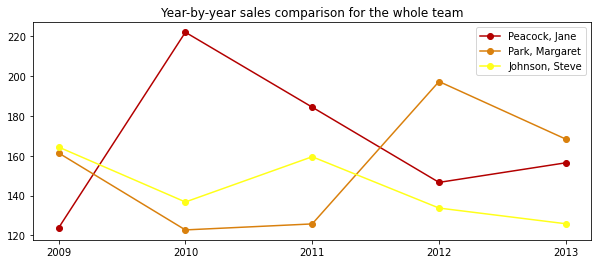

In [13]:
plt.figure(figsize=(10,4))
for i in range(3):
    record = records[:,i]
    plt.plot([*range(2009, 2014)], record, marker='o', color = (2-i)/2*C1+i/2*C2)
plt.xticks([*range(2009, 2014)])
plt.legend(['Peacock, Jane', 'Park, Margaret', 'Johnson, Steve'])
plt.title('Year-by-year sales comparison for the whole team')

Clearly, Jane was really dominant in 2010 and 2011, which explains her spot at the top of the leaderboard even though she hasn't been strongest in the last two years.

Let's do the same for monthly records to see if there are any seasonal trends

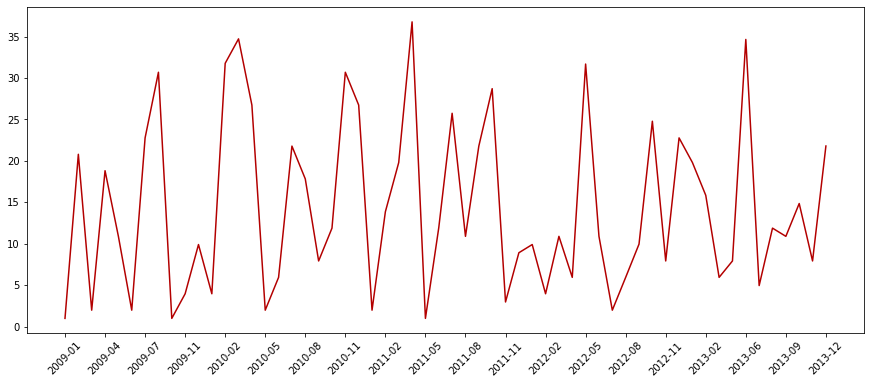

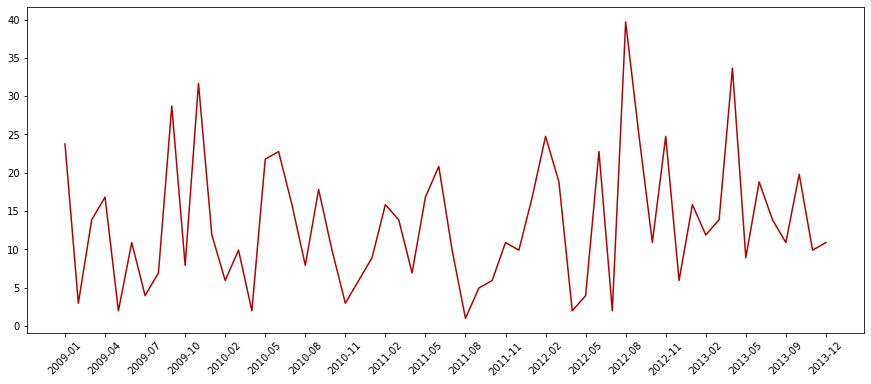

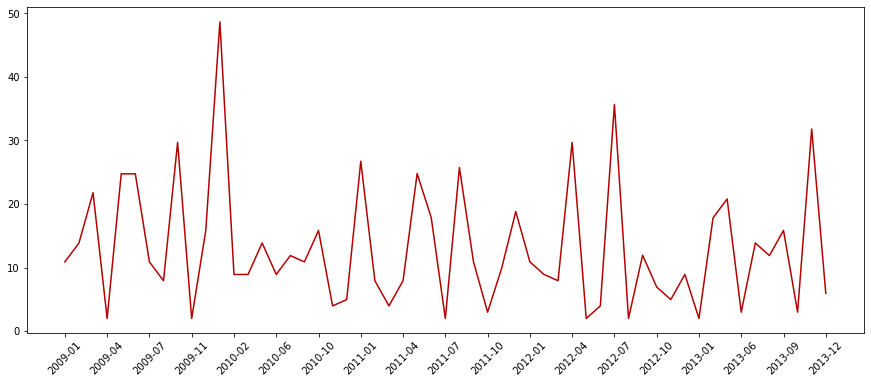

In [14]:
months = []
for year in range(2009, 2014):
    for month in range(1, 13):
        months.append(f'{year}-{month}')

for sales_id in sales_team.keys():
    query = pd.read_sql_query(f'''
        SELECT E.EMPLOYEEID, E.LASTNAME, E.FIRSTNAME, STRFTIME('%Y-%m', I.INVOICEDATE) AS 'date', I.INVOICEDATE, SUM(I.TOTAL) AS 'sales'
        FROM EMPLOYEES E 
        INNER JOIN CUSTOMERS C ON E.EMPLOYEEID = C.SUPPORTREPID
        INNER JOIN INVOICES I ON C.CUSTOMERID = I.CUSTOMERID
        WHERE E.EMPLOYEEID = {sales_id}
        GROUP BY STRFTIME('%Y-%m', I.INVOICEDATE)
    ''', conn)
    
    plt.figure(figsize=(15,6))
    plt.plot(query['date'], query['sales'], c=C1)
    plt.xticks([date for i, date in enumerate(query['date']) if i%3==0], rotation=45)

    

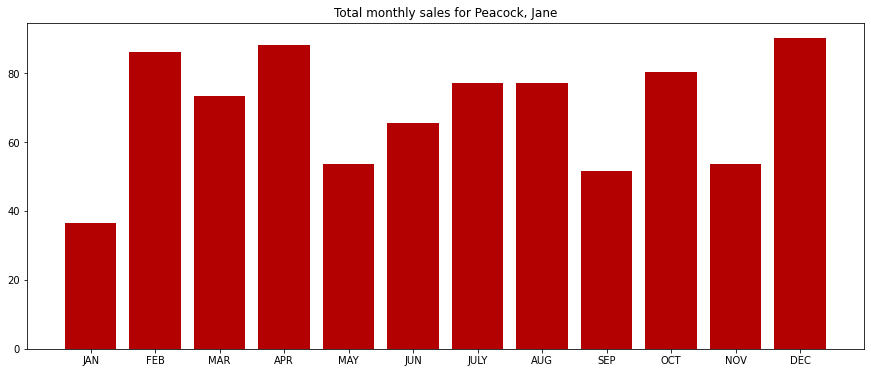

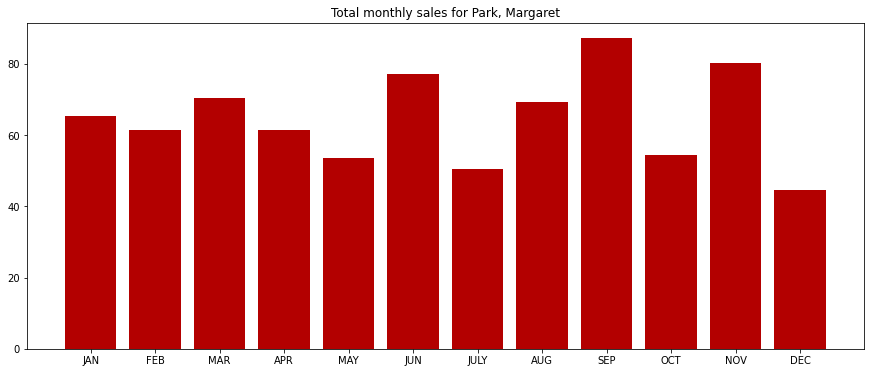

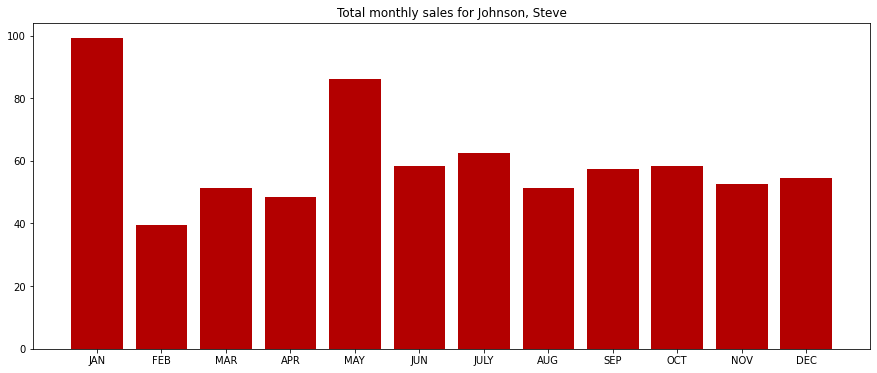

In [15]:
month_names = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

for sales_id in sales_team.keys():
    sales_by_month = np.zeros(12)
    for month in range(1, 13):
        query = pd.read_sql_query(f'''
            SELECT E.EMPLOYEEID, E.LASTNAME, E.FIRSTNAME, STRFTIME('%m', I.INVOICEDATE) AS 'month', I.INVOICEDATE, SUM(I.TOTAL) AS 'sales'
            FROM EMPLOYEES E 
            INNER JOIN CUSTOMERS C ON E.EMPLOYEEID = C.SUPPORTREPID
            INNER JOIN INVOICES I ON C.CUSTOMERID = I.CUSTOMERID
            WHERE E.EMPLOYEEID = {sales_id}
            AND STRFTIME('%m', I.INVOICEDATE) = '{str(month).zfill(2)}'
        ''', conn)

        sales_by_month[month-1] = query['sales']
        
    plt.figure(figsize=(15,6))
    plt.bar(month_names, sales_by_month, color=np.array([0.7, 0, 0]))
    plt.title(f'Total monthly sales for {sales_team[sales_id]}')
    # plt.xticks(month_names)

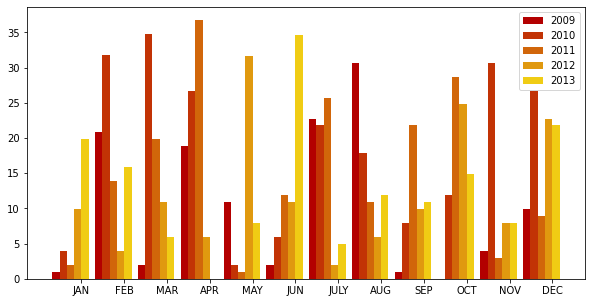

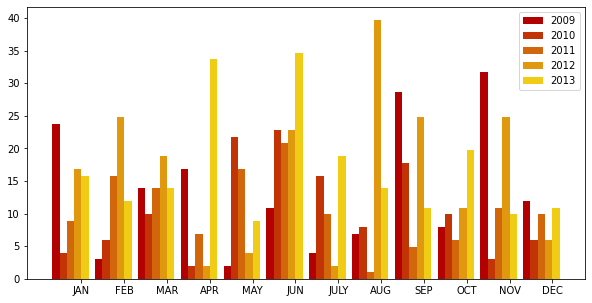

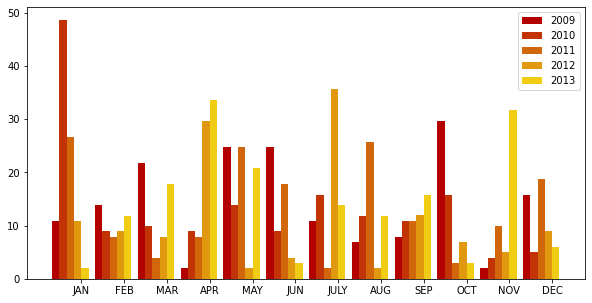

In [27]:
sales_matrix = np.zeros((12, 5))
for sales_id in sales_team:
    # aggregate data for each individual month from all the records
    for month in range(1, 13):
        month_str = str(month).zfill(2)
        query = pd.read_sql_query(F'''
            SELECT E.EMPLOYEEID, E.LASTNAME, E.FIRSTNAME, STRFTIME('%Y', I.INVOICEDATE) AS 'year', STRFTIME('%m', I.INVOICEDATE) AS 'month', I.INVOICEDATE, SUM(I.TOTAL) AS 'sales'
            FROM EMPLOYEES E 
            INNER JOIN CUSTOMERS C ON E.EMPLOYEEID = C.SUPPORTREPID
            INNER JOIN INVOICES I ON C.CUSTOMERID = I.CUSTOMERID
            WHERE E.EMPLOYEEID = {sales_id}
            AND STRFTIME('%m', I.INVOICEDATE) = '{str(month).zfill(2)}'
            GROUP BY STRFTIME('%Y', I.INVOICEDATE)
        ''', conn)
        for i, year in enumerate(range(2009, 2014)):
            sales = query[query['year']==str(year)]['sales']
            if sales.empty: continue
            sales_matrix[month-1, i] = sales
    # display data
    plt.figure(figsize=(10, 5))
    n = 5 # number of years / number of bars per group
    m = 12 # number of months / number of groups
    bar_width = 0.85/n
    C1 = np.array([0.7, 0, 0])
    C2 = np.array([1, 1, 0.1])
    for i in range(n):
        plt.bar(np.arange(m)-n*bar_width/2+i*bar_width, sales_matrix[:,i], width = bar_width, tick_label=month_names, align='edge', color=(n-i)/n*C1+i/n*C2)
        plt.legend([*range(2009, 2014)])

## City comparison

            BillingCity  Total sales
0                Prague        90.24
1                 Paris        77.24
2         Mountain View        77.24
3                Berlin        75.24
4             São Paulo        75.24
5                London        75.24
6            Fort Worth        47.62
7              Santiago        46.62
8                Dublin        45.62
9              Budapest        45.62
10       Salt Lake City        43.62
11            Frankfurt        43.62
12              Chicago        43.62
13               Vienne        42.62
14              Madison        42.62
15             Helsinki        41.62
16                Dijon        40.62
17            Amsterdam        40.62
18              Redmond        39.62
19               Lisbon        39.62
20  São José dos Campos        39.62
21                 Oslo        39.62
22              Orlando        39.62
23             Montréal        39.62
24             Bordeaux        39.62
25            Vancouver        38.62
2

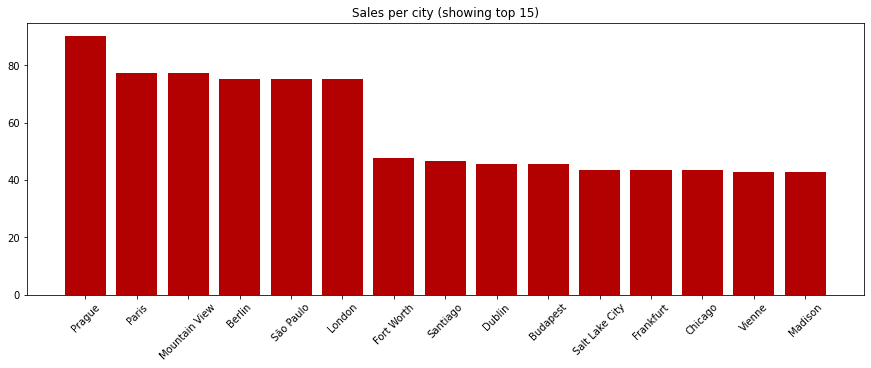

In [35]:
query = pd.read_sql_query('''
    SELECT BILLINGCITY, SUM(TOTAL) AS 'Total sales'
    FROM INVOICES
    GROUP BY BILLINGCITY
    ORDER BY SUM(TOTAL) DESC
''', conn)
cities = query['BillingCity']
print(query)
print(f'Average sales per city: {sum(query["Total sales"])/len(query)}')

plt.figure(figsize=(15, 5))
plt.bar(cities[:15], query['Total sales'][:15], color=C1)
plt.title('Sales per city (showing top 15)')
plt.xticks(rotation=45)
plt.show()

At first, Prague seems like a big outlier for sales value, more than double the average, with all but 6 of the cities falling below 50 value units. This data appears strange, so let's try to figure out what's really going on. 

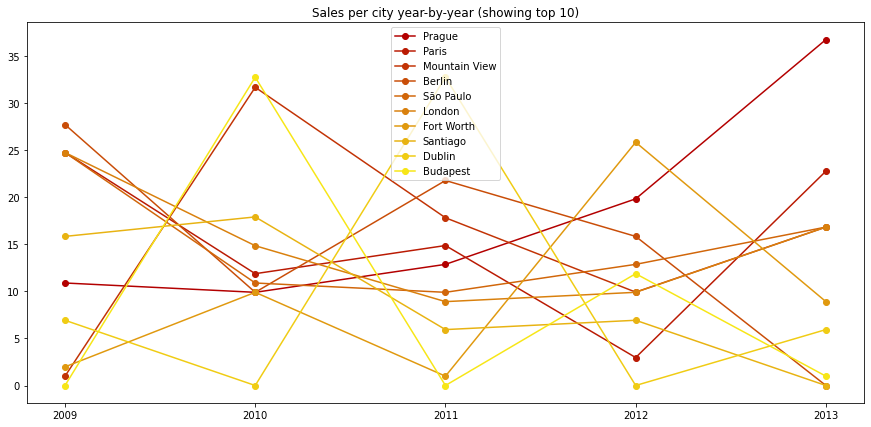

In [36]:
n = 10
plt.figure(figsize=(15, 7))
for i, city in enumerate(cities[:n]):
    query = pd.read_sql_query(f'''
        SELECT BILLINGCITY, SUM(TOTAL) AS 'Total sales', STRFTIME('%Y', INVOICEDATE) AS 'Year'
        FROM INVOICES
        WHERE BILLINGCITY = '{city}'
        GROUP BY Year
    ''', conn)
    sales_graph = np.zeros(5)
    for j, year in enumerate(range(2009, 2014)):
        if query[query['Year']==str(year)].empty: continue
        # print(query[query['Year']==str(year)]['Sales'])
        sales_graph[j] = query[query['Year']==str(year)]['Total sales']
    plt.plot([*range(2009, 2014)], sales_graph, c=(n-i)/n*C1+i/n*C2, marker='o')
plt.xticks([*range(2009, 2014)])
plt.legend(cities[:n])
plt.title('Sales per city year-by-year (showing top 10)')
plt.show()

Clearly, all cities have been part of the market for the same duration, so Prague doesn't seem to have any advantage, other than the Czech really liking music. Let's also take a look at what kind of music is popular in each city. We'll list the three most popular artists in each.

In [19]:
for city in cities:
    query = pd.read_sql_query(f'''
        SELECT AR.NAME, SUM(I.TOTAL) AS 'Total sales'
        FROM INVOICES I
        INNER JOIN INVOICE_ITEMS IT ON I.INVOICEID = IT.INVOICEID
        INNER JOIN TRACKS T ON IT.TRACKID = T.TRACKID
        INNER JOIN ALBUMS AL ON T.ALBUMID = AL.ALBUMID
        INNER JOIN ARTISTS AR ON AL.ARTISTID = AR.ARTISTID
        WHERE I.BILLINGCITY = '{city}'
        GROUP BY AR.ARTISTID
        ORDER BY SUM(I.TOTAL) DESC
    ''', conn)
    print(f"Top artists for {city}: {query['Name'][0]}, {query['Name'][1]}, {query['Name'][2]}")

Top artists for Prague: Lost, Iron Maiden, Heroes
Top artists for Paris: Red Hot Chili Peppers, Miles Davis, Various Artists
Top artists for Mountain View: Iron Maiden, Van Halen, Red Hot Chili Peppers
Top artists for Berlin: Iron Maiden, Deep Purple, Van Halen
Top artists for São Paulo: Pearl Jam, Deep Purple, R.E.M.
Top artists for London: Lulu Santos, Metallica, Marisa Monte
Top artists for Fort Worth: Lost, U2, Guns N' Roses
Top artists for Santiago: Lost, Heroes, Battlestar Galactica
Top artists for Dublin: Lost, U2, Guns N' Roses
Top artists for Budapest: The Office, Jamiroquai, Zeca Pagodinho
Top artists for Salt Lake City: The Rolling Stones, Battlestar Galactica (Classic), Faith No More
Top artists for Frankfurt: Foo Fighters, Gilberto Gil, Heroes
Top artists for Chicago: The Office, Led Zeppelin, Legião Urbana
Top artists for Vienne: U2, Lost, Iron Maiden
Top artists for Madison: The Office, Zeca Pagodinho, Iron Maiden
Top artists for Helsinki: Van Halen, Lenny Kravitz, Legiã

Let's also figure out which artist are the most popular:

In [38]:
query = pd.read_sql_query(f'''
    SELECT AR.NAME, SUM(IT.UNITPRICE*IT.QUANTITY) AS 'Total sales'
    FROM INVOICES I
    INNER JOIN INVOICE_ITEMS IT ON I.INVOICEID = IT.INVOICEID
    INNER JOIN TRACKS T ON IT.TRACKID = T.TRACKID
    INNER JOIN ALBUMS AL ON T.ALBUMID = AL.ALBUMID
    INNER JOIN ARTISTS AR ON AL.ARTISTID = AR.ARTISTID
    GROUP BY AR.ARTISTID
    ORDER BY SUM(IT.UNITPRICE*IT.QUANTITY) DESC
''', conn)
print(query)

                                 Name  Total sales
0                         Iron Maiden       138.60
1                                  U2       105.93
2                           Metallica        90.09
3                        Led Zeppelin        86.13
4                                Lost        81.59
..                                ...          ...
160  English Concert & Trevor Pinnock         0.99
161      Luciana Souza/Romero Lubambo         0.99
162                        The Posies         0.99
163            Habib Koité and Bamada         0.99
164                    Dread Zeppelin         0.99

[165 rows x 2 columns]


## Top Charts

Let's figure out which track has been the most popular over the last 3 months

In [20]:
query = pd.read_sql_query(f'''
    SELECT T.NAME, T.UNITPRICE, SUM(IT.UNITPRICE*IT.QUANTITY) AS 'Total sales', SUM(IT.QUANTITY) AS 'Number sold'
    FROM INVOICES I
    INNER JOIN INVOICE_ITEMS IT ON I.INVOICEID = IT.INVOICEID
    INNER JOIN TRACKS T ON IT.TRACKID = T.TRACKID
    GROUP BY T.TRACKID
    ORDER BY SUM(I.TOTAL) DESC
''', conn)
print(query)

                   Name  UnitPrice  Total sales  Number sold
0        The Woman King       1.99         3.98            2
1               The Fix       1.99         3.98            2
2             Walkabout       1.99         3.98            2
3     Phyllis's Wedding       1.99         3.98            2
4            Insensível       0.99         0.99            1
...                 ...        ...          ...          ...
1979  Carnival Of Sorts       0.99         0.99            1
1980              Plush       0.99         0.99            1
1981            Go Back       0.99         0.99            1
1982             Desire       0.99         0.99            1
1983           Slowness       0.99         0.99            1

[1984 rows x 4 columns]


Sales have not exactly been booming. Anyways, let's take a look at just the last 3 months.

In [21]:
query = pd.read_sql_query(f'''
    SELECT T.NAME, T.UNITPRICE, SUM(IT.QUANTITY) AS 'Number sold', SUM(IT.UNITPRICE*IT.QUANTITY) AS 'Total sales'
    FROM INVOICES I
    INNER JOIN INVOICE_ITEMS IT ON I.INVOICEID = IT.INVOICEID
    INNER JOIN TRACKS T ON IT.TRACKID = T.TRACKID
    WHERE STRFTIME('%Y%m', I.INVOICEDATE) >= '201310'
    GROUP BY T.TRACKID
    ORDER BY 2 DESC, 1 ASC
''', conn)
print(tabulate(query, headers='keys', tablefmt='plain'))

     Name                                                   UnitPrice    Number sold    Total sales
  0  Collaborators                                               1.99              1           1.99
  1  Deus Ex Machina                                             1.99              1           1.99
  2  Hot Girl                                                    1.99              1           1.99
  3  Live Together, Die Alone, Pt. 1                             1.99              1           1.99
  4  Man of Science, Man of Faith (Premiere)                     1.99              1           1.99
  5  One Giant Leap                                              1.99              1           1.99
  6  Outlaws                                                     1.99              1           1.99
  7  Par Avion                                                   1.99              1           1.99
  8  Stranger In a Strange Land                                  1.99              1           1.99
